In [2]:
cd(@__DIR__);
println(pwd());

using Pkg;
Pkg.activate(pwd());
packages = ["Plots","Glob","JLD2","BenchmarkTools","Distributions","SymbolicRegression","SymbolicUtils","LaTeXStrings"]
deps = Pkg.project().dependencies;
for pkg in packages
    if pkg ∉ keys(deps)
        Pkg.add(pkg);
    end
end

/home/vfegger/projects/HTSR


  Activating project at `~/projects/HTSR`


Pkg.Types.PkgError: The following package names could not be resolved:
 * JDL2 (not found in project, manifest or registry)
[36m   Suggestions:[39m [0m[1mj[22m[0m[1md[22m_j[0m[1ml[22ml [0m[1mJ[22mu[0m[1md[22mi[0m[1mL[22ming [0m[1mJ[22mu[0m[1md[22mi[0m[1mL[22mingMeasures [0m[1mJ[22mus[0m[1md[22m[0m[1ml[22m ML[0m[1mJ[22mMo[0m[1md[22me[0m[1ml[22ms

In [46]:
using SymbolicRegression

n = 100

X = Array{Float32,2}(undef, 2, n^2)
Ra = @view X[1, :]
Pr = @view X[2, :]
#Re = @view X[3, :]

#Re .= range(1.0e2, 1.0e5, n)
Pr_ref = collect(range(0.5, 10.0, n))
Ra_ref = collect(range(1.0e2, 1.0e8, n))
for i in 1:n
    for j in 1:n
        Pr[(i-1)*n+j] = Pr_ref[i]
        Ra[(i-1)*n+j] = Ra_ref[j]
    end
end

y = 0.68 .+ 0.663 .* Ra .^ (1.0 / 4.0) ./ (1.0 .+ (0.492 ./ Pr) .^ (9.0 / 16.0)) .^ (4.0 / 9.0)

options = Options(
    binary_operators=(+, *, /, -, ^),
    unary_operators=(cos, exp),
    npopulations=25
)

hallOfFame = equation_search(X, y, niterations=20, options=options, parallelism=:multithreading)

HallOfFame{Float64, Float64, Node{Float64}}(PopMember{Float64, Float64, Node{Float64}}[PopMember{Float64, Float64, Node{Float64}}(47.45612050548102, 1.003199999919161, 111.29607932410578, 17192578527193120, 1, 2376118497536476513, 7847560239474956655), PopMember{Float64, Float64, Node{Float64}}(exp(3.124703249967409), 6.489406648134356, 721.5332221874606, 17192580317186420, 2, 6251896363209898079, 5950795073184048682), PopMember{Float64, Float64, Node{Float64}}(x2 + 42.20612053292552, 0.9786425199948834, 107.85063322668618, 17192577953734460, 3, 3545410890190303934, 8853438890613182468), PopMember{Float64, Float64, Node{Float64}}(47.46209350285538 - cos(x1), 1.010462085161311, 111.03587860475425, 17192578191747470, 4, 8029364590899111145, 4853640288006852869), PopMember{Float64, Float64, Node{Float64}}((x1 ^ 0.24648510330192028) * 0.6337940749351937, 0.06399412275717858, 5.34155781619844, 17192583072741448, 5, 3337119151852090800, 8851344638962225482), PopMember{Float64, Float64, Node{

In [47]:
dominating = calculate_pareto_frontier(X, y, hallOfFame, options)

trees = [member.tree for member in dominating]

11-element Vector{Node{Float64}}:
 47.45612050548102
 x2 + 42.20612053292552
 (x1 ^ 0.24648510330192028) * 0.6337940749351937
 (x1 ^ 0.22316324345281993) - (6.543442982263146 / x2)
 (-6.323037744460461 / x2) + ((x1 ^ 0.23403075806519275) * 0.8233016861784186)
 (x1 ^ 0.22316324345281993) - ((6.543442982263146 - cos(x2)) / x2)
 ((x1 ^ 0.22432293398682504) - (18.36820042084227 / (x2 + 1.1233816629262876))) + 0.5534917572971231
 (((x1 + 18.36820042084227) ^ 0.22432293398682504) - (18.36820042084227 / (x2 + 1.1233816629262876))) + 0.5534917572971231
 (cos(0.80072113141243 ^ (x2 + 1.7644213286406574)) * ((x1 ^ 0.24783827062857197) / 1.548924333738902)) - -0.045567142662967464
 (((x1 ^ 0.2506891239957221) / 1.6598995813456106) * cos(0.782395250797107 ^ ((x2 - 0.40030765442749494) + 1.8980511685105408))) + 0.8201777260953514
 (cos(0.7897370416329385 ^ (x2 + 1.608923485698129)) * ((((x1 + x1) ^ 0.25077473860255517) - 0.2718202792988201) / 1.9750513054812775)) + 0.9310735992486661

In [48]:
using SymbolicUtils

eqn = node_to_symbolic(dominating[end].tree, options)
println(simplify(eqn))

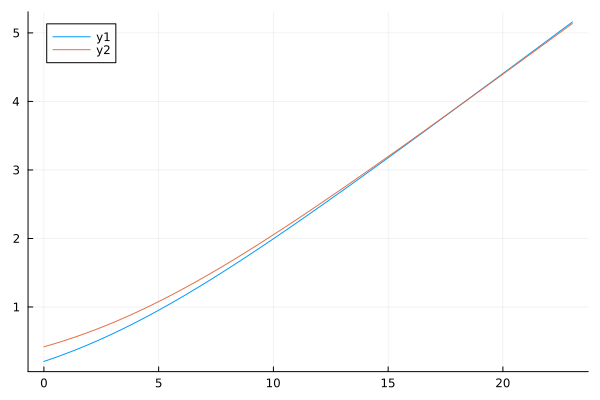

In [49]:
using Plots

points = exp10.(range(0.0f0, 10.0f0, 1000))
Pr_test = 1.5

f(x) = 0.68 .+ 0.663 .* x .^ (1.0 / 4.0) ./ (1.0 .+ (0.492 ./ Pr_test) .^ (9.0 / 16.0)) .^ (4.0 / 9.0)

tree = trees[end]
Y = Array{Float64,2}(undef, 2, length(points))
Y[1, :] .= points
Y[2, :] .= Pr_test
result,worked = eval_tree_array(tree, Y, options)

if worked
    plot(log.(points), [log.(f.(points)) log.(h.(points))])
else
    println("NaN or Infinity detected.")
end